In [1]:
# TensorFlow and tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

2.0.0-alpha0


Import data:

In [2]:
grid = 32
traindata = np.load('train_data.npz')
testdata = np.load('test_data.npz')
trainimages = traindata['circles']
testimages = testdata['circles']
trainlabels = traindata['labels']
testlabels = testdata['labels']
toshuffletrain = np.hstack((trainimages, trainlabels))
np.random.shuffle(toshuffletrain)
n_test = len(testlabels)
n_train = len(trainlabels)
trainimages = toshuffletrain[:,:-1].reshape(n_train, grid, grid, 1)
trainlabels = toshuffletrain[:,-1:]
toshuffletest = np.hstack((testimages, testlabels))
testimages = toshuffletest[:,:-1].reshape(n_test, grid, grid, 1)
testlabels = toshuffletest[:,-1:]

Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

1 == signal, 0 == bg 
[1.]


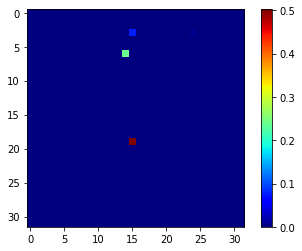

In [3]:
display = testimages[60].reshape(grid,grid)
plt.grid(False)
plt.imshow(display, cmap = 'jet')
print("1 == signal, 0 == bg ")
print(testlabels[60])
plt.colorbar()

Build DNN:

In [4]:
def build_model():
    model = keras.Sequential([
        Conv2D(32, (11, 11), activation='relu',
               input_shape=(grid, grid, 1)),
        Conv2D(32, (3, 3), activation='relu'
              ),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Conv2D(32, (3, 3), activation='relu'
              ),
        Conv2D(32, (3, 3), activation='relu'
              ),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Flatten(),
        Dense(64, activation=tf.nn.relu),
        Dense(64, activation=tf.nn.relu),
#         Dropout(0.2),
        Dense(1, activation=tf.nn.sigmoid)
      ])

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [5]:
circleCNN = build_model()

Test model's prediction $before$ training:

In [6]:
example_batch = trainimages[:10]
example_labels = trainlabels[:10]
example_result = circleCNN.predict(example_batch)
results = circleCNN.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 7ms/sample - loss: 0.6934 - mean_squared_error: 0.2501 - binary_crossentropy: 0.6934 - accuracy: 0.3000


array([[0.4997302 ],
       [0.499853  ],
       [0.5000796 ],
       [0.4999754 ],
       [0.5002974 ],
       [0.49982947],
       [0.50032234],
       [0.50007343],
       [0.4997947 ],
       [0.5003739 ]], dtype=float32)

Now train! (warning: if building CNN, computer tends to get loud)

In [7]:
 class PrintDot(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs):
     if epoch % 100 == 0: 
         print('')
     print('.', end='')
    
checkpoint_path = "training/CNN_sparce_cat.h5"


# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
 EPOCHS = 1000
 early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
 history = circleCNN.fit(
   trainimages, trainlabels,
   epochs=EPOCHS, validation_split = 0.2, verbose = 0,
   callbacks=[early_stop, model_checkpoint])


Epoch 00001: val_loss improved from inf to 0.41453, saving model to training/CNN_sparce_cat.h5

Epoch 00002: val_loss improved from 0.41453 to 0.37155, saving model to training/CNN_sparce_cat.h5

Epoch 00003: val_loss improved from 0.37155 to 0.33352, saving model to training/CNN_sparce_cat.h5

Epoch 00004: val_loss improved from 0.33352 to 0.33265, saving model to training/CNN_sparce_cat.h5

Epoch 00005: val_loss improved from 0.33265 to 0.30470, saving model to training/CNN_sparce_cat.h5

Epoch 00006: val_loss improved from 0.30470 to 0.29617, saving model to training/CNN_sparce_cat.h5

Epoch 00007: val_loss did not improve from 0.29617

Epoch 00008: val_loss did not improve from 0.29617

Epoch 00009: val_loss did not improve from 0.29617

Epoch 00010: val_loss did not improve from 0.29617

Epoch 00011: val_loss did not improve from 0.29617

Epoch 00012: val_loss did not improve from 0.29617

Epoch 00013: val_loss did not improve from 0.29617

Epoch 00014: val_loss did not improve f

Now make a plot that shows the pregression of accuracy through each training epoch.

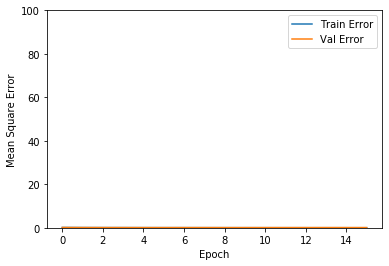

In [10]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.show()

plot_history(history)

Load best weights.

In [11]:
!ls training
best_model = tf.keras.models.load_model('training/CNN_sparce_cat.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels)

CNN_sparce_cat.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        3904      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 28

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

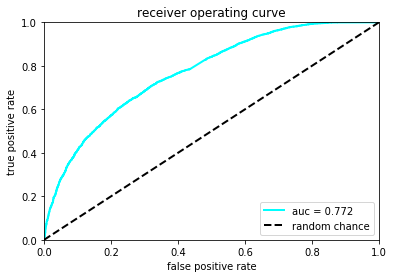

In [22]:
# Plot ROC
Y_predict = circleCNN.predict(testimages)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels, Y_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()